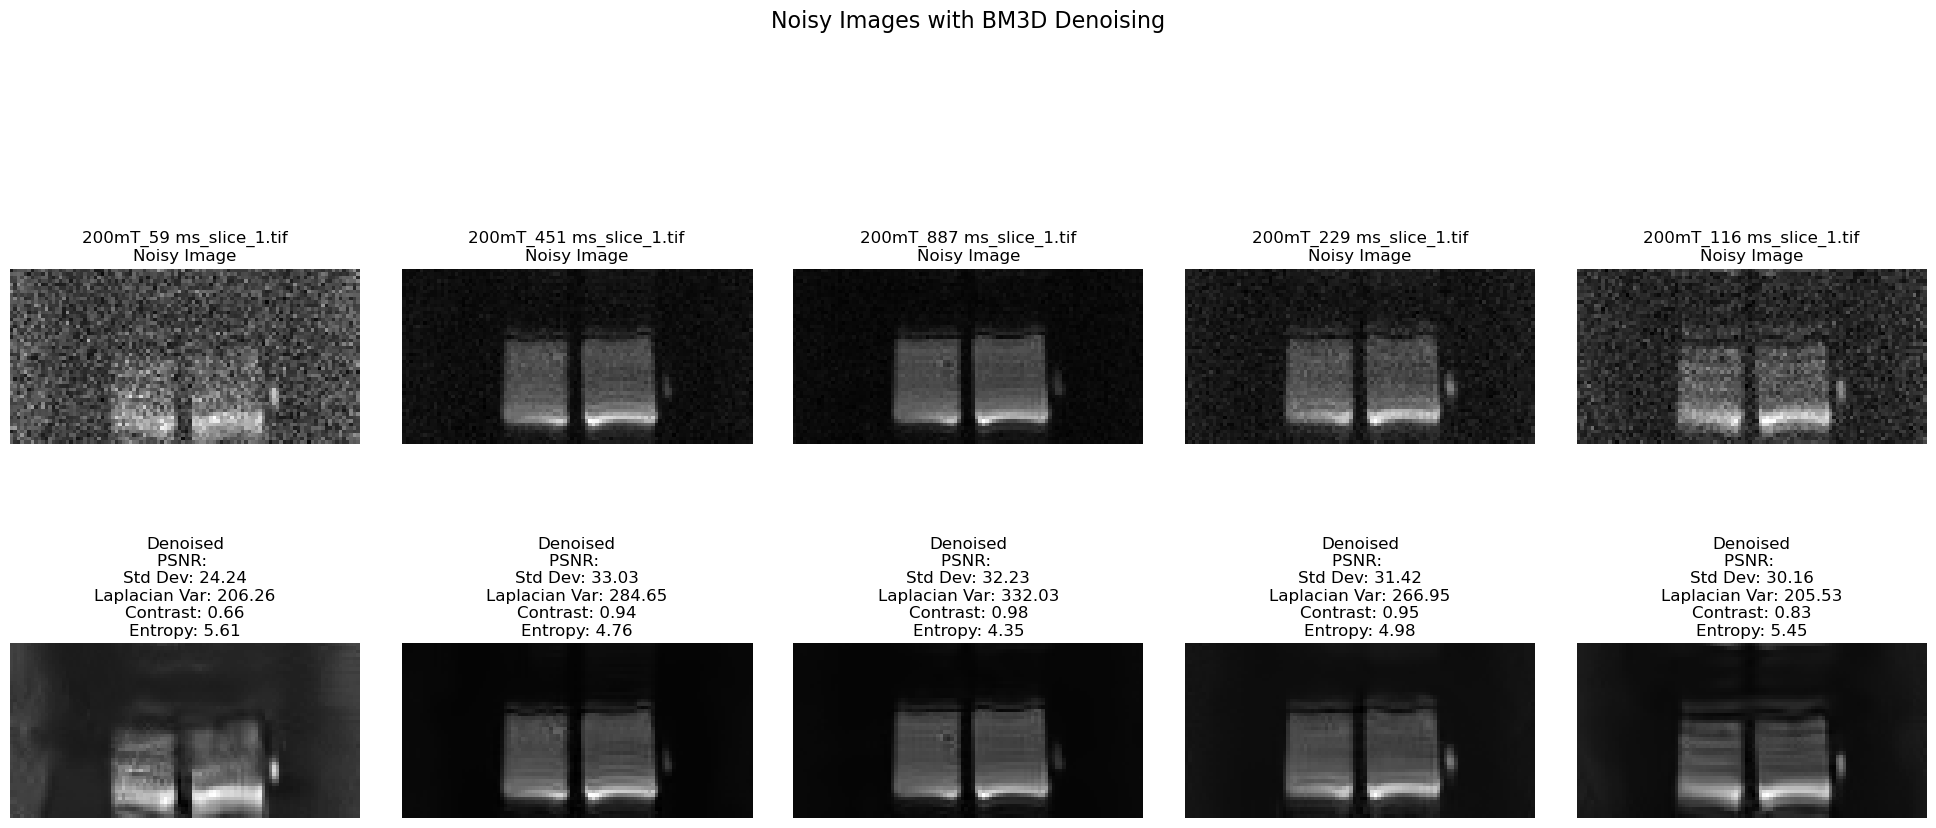

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import estimate_sigma
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from scipy.stats import entropy as scipy_entropy
from skimage.filters import laplace
import os
from skimage import io
import bm3d
import re

def compute_nr_iqa(image):
    """
    Calculates no-reference image quality assessment (NR-IQA) features for a given image.

    Args:
        image (np.ndarray): The grayscale image for which to calculate NR-IQA features.

    Returns:
        dict: A dictionary containing the calculated NR-IQA features:
            - Standard Deviation: Standard deviation of pixel intensity values.
            - Laplacian Variance: Variance of the Laplacian filter applied to the image.
            - Contrast (Michelson): Michelson contrast measure based on minimum and maximum intensities.
            - Entropy: Image entropy calculated using skimage.metrics.entropy.
    """

    std_dev = np.std(image)
    laplacian_img = laplace(image, ksize=3)  # Apply the Laplacian filter
    laplacian_var = np.var(laplacian_img)  # Compute the variance of the Laplacian
    contrast = (np.max(image) - np.min(image)) / (np.max(image) + np.min(image))
    # Calculate global entropy
    hist, _ = np.histogram(image, bins=256, range=(0, 256))
    prob_dist = hist / np.sum(hist)
    entropy_val = scipy_entropy(prob_dist, base=2)

    return {
        'Standard Deviation': std_dev,
        'Laplacian Variance': laplacian_var,
        'Contrast (Michelson)': contrast,
        'Entropy': entropy_val,
    }


def extract_mT_value(filename):
    match = re.search(r'(\d+)_mT', filename)
    return int(match.group(1)) if match else 0

def create_background_mask(image_gray):
    thresh = threshold_otsu(image_gray)
    binary_image = image_gray <= thresh
    cleared_image = clear_border(binary_image)
    label_image = label(cleared_image)
    regions = regionprops(label_image)
    largest_area = 0
    background_label = 0
    for region in regions:
        if region.area > largest_area:
            largest_area = region.area
            background_label = region.label
    background_mask = label_image == background_label
    return background_mask

def denoise_medical_phantom(directory):
    # Get a list of all .tif files in the directory
    file_list = [file for file in os.listdir(directory) if file.endswith('.tif')]

    # Sort file_list based on the mT values extracted from filenames
    file_list.sort(key=extract_mT_value)

    plt.figure(figsize=(20, 10))

    for i, filename in enumerate(file_list):
        # Read the image
        image = io.imread(os.path.join(directory, filename))

        # Convert to grayscale if it's a multichannel image
        if image.ndim == 3 and image.shape[2] == 3:
            image_gray = rgb2gray(image)
        else:
            image_gray = image

        sigma_est = np.mean(estimate_sigma(image_gray))
        background_mask = create_background_mask(image_gray)

        # Apply BM3D Denoising
        denoised_image = bm3d.bm3d(image_gray, sigma_psd=sigma_est)
        

        # For denoised image, let's also calculate the standard deviation for comparison
        std_deviation_denoised = np.std(denoised_image[background_mask])
        
        nr_iqa_metrics = compute_nr_iqa(denoised_image)

        plt.subplot(2, len(file_list), i + 1)
        plt.imshow(image_gray, cmap='gray', interpolation='nearest')
        plt.title(f'{filename}\nNoisy Image')
        plt.axis('off')

        plt.subplot(2, len(file_list), i + len(file_list) + 1)
        plt.imshow(denoised_image, cmap='gray', interpolation='nearest')
        plt.title(f'Denoised\nPSNR: \nStd Dev: {nr_iqa_metrics["Standard Deviation"]:.2f}\nLaplacian Var: {nr_iqa_metrics["Laplacian Variance"]:.2f}\nContrast: {nr_iqa_metrics["Contrast (Michelson)"]:.2f}\nEntropy: {nr_iqa_metrics["Entropy"]:.2f}')
        plt.axis('off')

    # Set custom ticks for x-axis based on the number of images
    x_ticks_positions = np.linspace(0, 2 * (len(file_list) - 1), len(file_list))
    x_tick_labels = [0, 2, 20] + [200] * (len(file_list) - 3)
    plt.xticks(x_ticks_positions, x_tick_labels)

    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.85)
    plt.suptitle('Noisy Images with BM3D Denoising', fontsize=16, y=0.98)
    plt.show()

# Example usage:
directory = '../TraditionalMethods/Experiments/PhantomData/200mT/'
denoise_medical_phantom(directory)


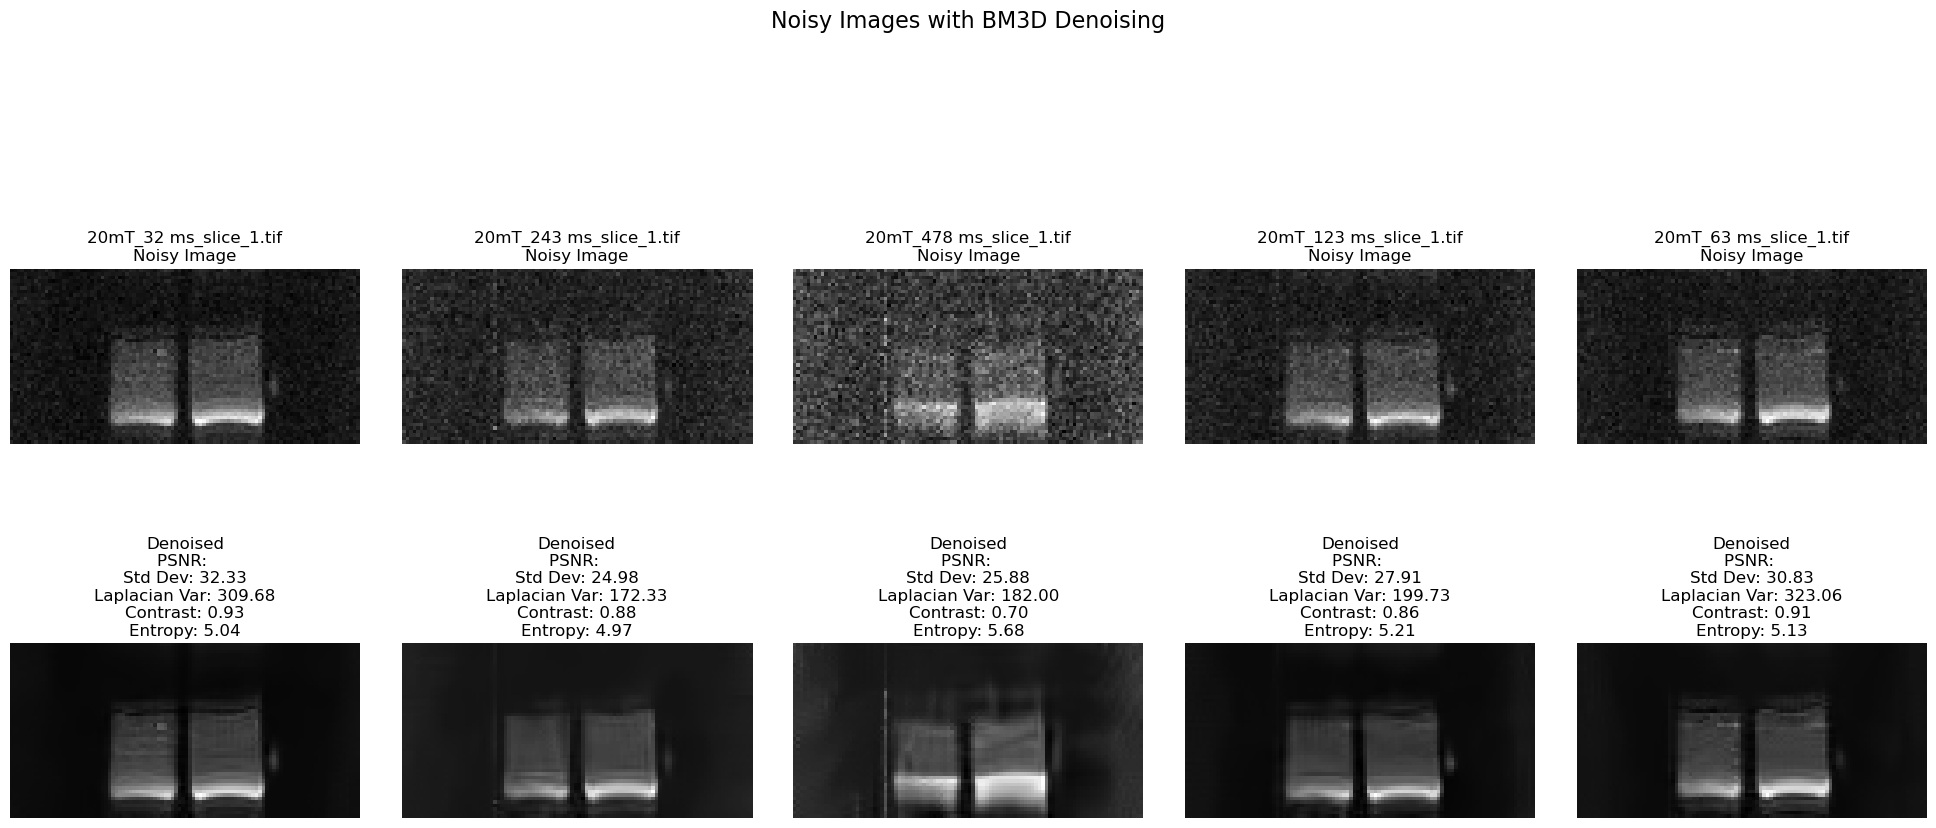

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import estimate_sigma
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from scipy.stats import entropy as scipy_entropy
from skimage.filters import laplace
import os
from skimage import io
import bm3d
import re

def compute_nr_iqa(image):
    """
    Calculates no-reference image quality assessment (NR-IQA) features for a given image.

    Args:
        image (np.ndarray): The grayscale image for which to calculate NR-IQA features.

    Returns:
        dict: A dictionary containing the calculated NR-IQA features:
            - Standard Deviation: Standard deviation of pixel intensity values.
            - Laplacian Variance: Variance of the Laplacian filter applied to the image.
            - Contrast (Michelson): Michelson contrast measure based on minimum and maximum intensities.
            - Entropy: Image entropy calculated using skimage.metrics.entropy.
    """

    std_dev = np.std(image)
    laplacian_img = laplace(image, ksize=3)  # Apply the Laplacian filter
    laplacian_var = np.var(laplacian_img)  # Compute the variance of the Laplacian
    contrast = (np.max(image) - np.min(image)) / (np.max(image) + np.min(image))
    # Calculate global entropy
    hist, _ = np.histogram(image, bins=256, range=(0, 256))
    prob_dist = hist / np.sum(hist)
    entropy_val = scipy_entropy(prob_dist, base=2)

    return {
        'Standard Deviation': std_dev,
        'Laplacian Variance': laplacian_var,
        'Contrast (Michelson)': contrast,
        'Entropy': entropy_val,
    }


def extract_mT_value(filename):
    match = re.search(r'(\d+)_mT', filename)
    return int(match.group(1)) if match else 0

def create_background_mask(image_gray):
    thresh = threshold_otsu(image_gray)
    binary_image = image_gray <= thresh
    cleared_image = clear_border(binary_image)
    label_image = label(cleared_image)
    regions = regionprops(label_image)
    largest_area = 0
    background_label = 0
    for region in regions:
        if region.area > largest_area:
            largest_area = region.area
            background_label = region.label
    background_mask = label_image == background_label
    return background_mask

def denoise_medical_phantom(directory):
    # Get a list of all .tif files in the directory
    file_list = [file for file in os.listdir(directory) if file.endswith('.tif')]

    # Sort file_list based on the mT values extracted from filenames
    file_list.sort(key=extract_mT_value)

    plt.figure(figsize=(20, 10))

    for i, filename in enumerate(file_list):
        # Read the image
        image = io.imread(os.path.join(directory, filename))

        # Convert to grayscale if it's a multichannel image
        if image.ndim == 3 and image.shape[2] == 3:
            image_gray = rgb2gray(image)
        else:
            image_gray = image

        sigma_est = np.mean(estimate_sigma(image_gray))
        background_mask = create_background_mask(image_gray)

        # Apply BM3D Denoising
        denoised_image = bm3d.bm3d(image_gray, sigma_psd=sigma_est)
        

        # For denoised image, let's also calculate the standard deviation for comparison
        std_deviation_denoised = np.std(denoised_image[background_mask])
        
        nr_iqa_metrics = compute_nr_iqa(denoised_image)

        plt.subplot(2, len(file_list), i + 1)
        plt.imshow(image_gray, cmap='gray', interpolation='nearest')
        plt.title(f'{filename}\nNoisy Image')
        plt.axis('off')

        plt.subplot(2, len(file_list), i + len(file_list) + 1)
        plt.imshow(denoised_image, cmap='gray', interpolation='nearest')
        plt.title(f'Denoised\nPSNR: \nStd Dev: {nr_iqa_metrics["Standard Deviation"]:.2f}\nLaplacian Var: {nr_iqa_metrics["Laplacian Variance"]:.2f}\nContrast: {nr_iqa_metrics["Contrast (Michelson)"]:.2f}\nEntropy: {nr_iqa_metrics["Entropy"]:.2f}')
        plt.axis('off')

    # Set custom ticks for x-axis based on the number of images
    x_ticks_positions = np.linspace(0, 2 * (len(file_list) - 1), len(file_list))
    x_tick_labels = [0, 2, 20] + [200] * (len(file_list) - 3)
    plt.xticks(x_ticks_positions, x_tick_labels)

    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.85)
    plt.suptitle('Noisy Images with BM3D Denoising', fontsize=16, y=0.98)
    plt.show()

# Example usage:
directory = '../TraditionalMethods/Experiments/PhantomData/20mT/'
denoise_medical_phantom(directory)


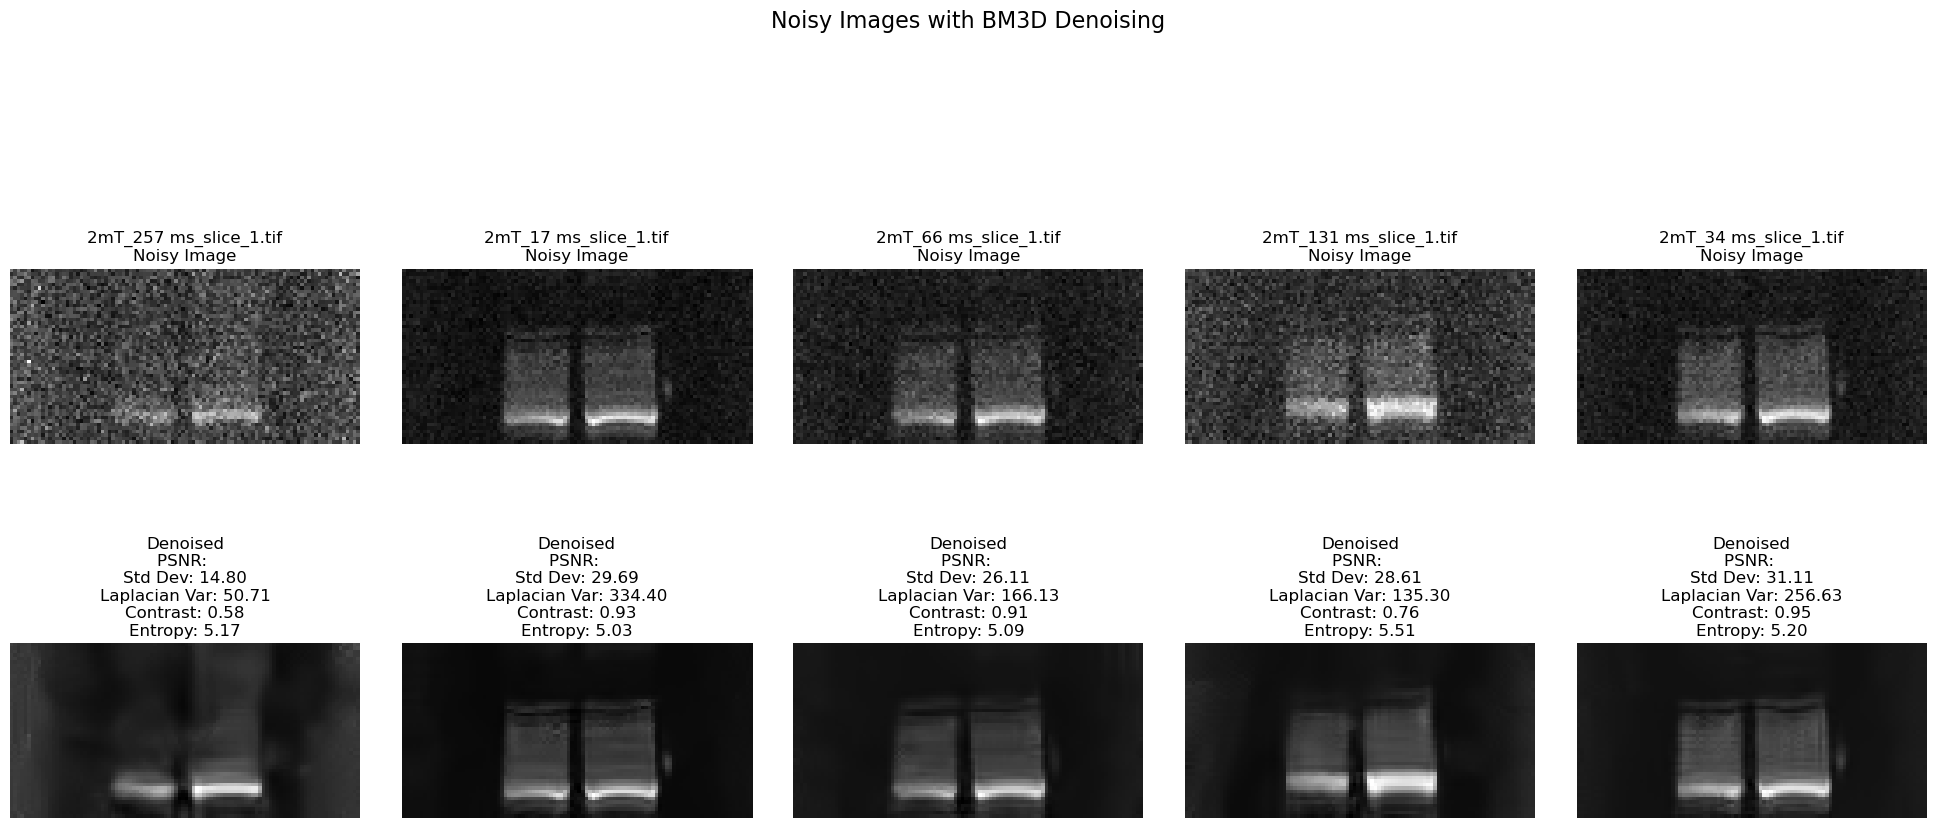

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import estimate_sigma
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from scipy.stats import entropy as scipy_entropy
from skimage.filters import laplace
import os
from skimage import io
import bm3d
import re

def compute_nr_iqa(image):
    """
    Calculates no-reference image quality assessment (NR-IQA) features for a given image.

    Args:
        image (np.ndarray): The grayscale image for which to calculate NR-IQA features.

    Returns:
        dict: A dictionary containing the calculated NR-IQA features:
            - Standard Deviation: Standard deviation of pixel intensity values.
            - Laplacian Variance: Variance of the Laplacian filter applied to the image.
            - Contrast (Michelson): Michelson contrast measure based on minimum and maximum intensities.
            - Entropy: Image entropy calculated using skimage.metrics.entropy.
    """

    std_dev = np.std(image)
    laplacian_img = laplace(image, ksize=3)  # Apply the Laplacian filter
    laplacian_var = np.var(laplacian_img)  # Compute the variance of the Laplacian
    contrast = (np.max(image) - np.min(image)) / (np.max(image) + np.min(image))
    # Calculate global entropy
    hist, _ = np.histogram(image, bins=256, range=(0, 256))
    prob_dist = hist / np.sum(hist)
    entropy_val = scipy_entropy(prob_dist, base=2)

    return {
        'Standard Deviation': std_dev,
        'Laplacian Variance': laplacian_var,
        'Contrast (Michelson)': contrast,
        'Entropy': entropy_val,
    }


def extract_mT_value(filename):
    match = re.search(r'(\d+)_mT', filename)
    return int(match.group(1)) if match else 0

def create_background_mask(image_gray):
    thresh = threshold_otsu(image_gray)
    binary_image = image_gray <= thresh
    cleared_image = clear_border(binary_image)
    label_image = label(cleared_image)
    regions = regionprops(label_image)
    largest_area = 0
    background_label = 0
    for region in regions:
        if region.area > largest_area:
            largest_area = region.area
            background_label = region.label
    background_mask = label_image == background_label
    return background_mask

def denoise_medical_phantom(directory):
    # Get a list of all .tif files in the directory
    file_list = [file for file in os.listdir(directory) if file.endswith('.tif')]

    # Sort file_list based on the mT values extracted from filenames
    file_list.sort(key=extract_mT_value)

    plt.figure(figsize=(20, 10))

    for i, filename in enumerate(file_list):
        # Read the image
        image = io.imread(os.path.join(directory, filename))

        # Convert to grayscale if it's a multichannel image
        if image.ndim == 3 and image.shape[2] == 3:
            image_gray = rgb2gray(image)
        else:
            image_gray = image

        sigma_est = np.mean(estimate_sigma(image_gray))
        background_mask = create_background_mask(image_gray)

        # Apply BM3D Denoising
        denoised_image = bm3d.bm3d(image_gray, sigma_psd=sigma_est)
        

        # For denoised image, let's also calculate the standard deviation for comparison
        std_deviation_denoised = np.std(denoised_image[background_mask])
        
        nr_iqa_metrics = compute_nr_iqa(denoised_image)

        plt.subplot(2, len(file_list), i + 1)
        plt.imshow(image_gray, cmap='gray', interpolation='nearest')
        plt.title(f'{filename}\nNoisy Image')
        plt.axis('off')

        plt.subplot(2, len(file_list), i + len(file_list) + 1)
        plt.imshow(denoised_image, cmap='gray', interpolation='nearest')
        plt.title(f'Denoised\nPSNR: \nStd Dev: {nr_iqa_metrics["Standard Deviation"]:.2f}\nLaplacian Var: {nr_iqa_metrics["Laplacian Variance"]:.2f}\nContrast: {nr_iqa_metrics["Contrast (Michelson)"]:.2f}\nEntropy: {nr_iqa_metrics["Entropy"]:.2f}')
        plt.axis('off')

    # Set custom ticks for x-axis based on the number of images
    x_ticks_positions = np.linspace(0, 2 * (len(file_list) - 1), len(file_list))
    x_tick_labels = [0, 2, 20] + [200] * (len(file_list) - 3)
    plt.xticks(x_ticks_positions, x_tick_labels)

    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.85)
    plt.suptitle('Noisy Images with BM3D Denoising', fontsize=16, y=0.98)
    plt.show()

# Example usage:
directory = '../TraditionalMethods/Experiments/PhantomData/2mT/'
denoise_medical_phantom(directory)


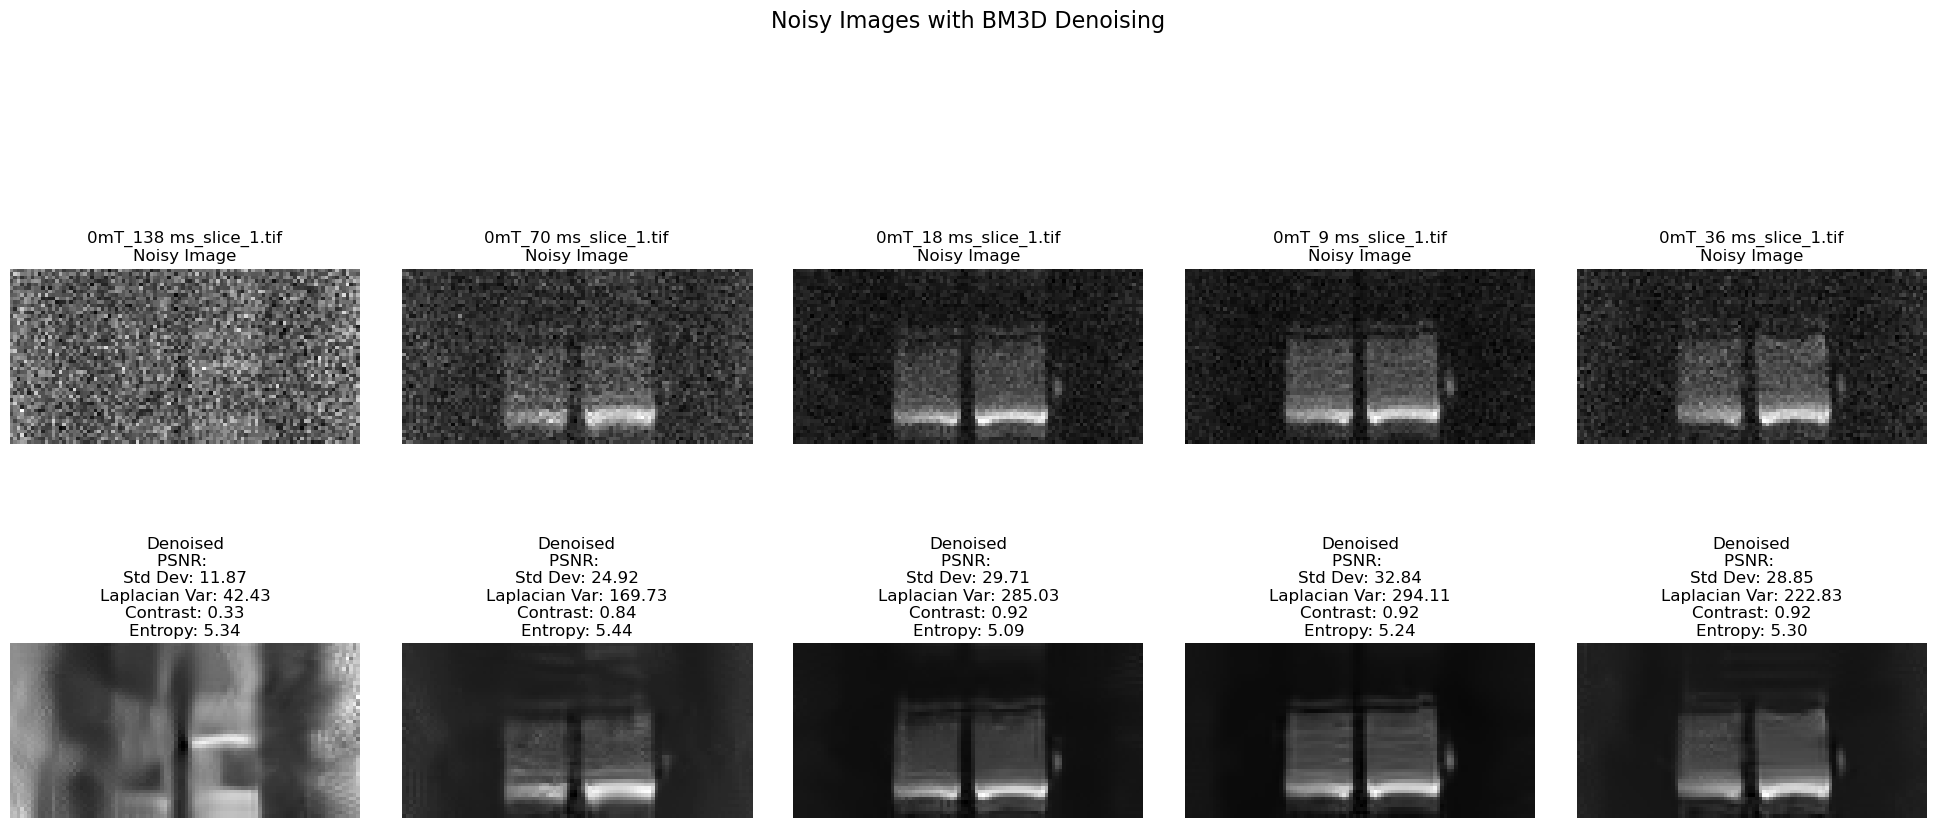

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import estimate_sigma
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from scipy.stats import entropy as scipy_entropy
from skimage.filters import laplace
import os
from skimage import io
import bm3d
import re

def compute_nr_iqa(image):
    """
    Calculates no-reference image quality assessment (NR-IQA) features for a given image.

    Args:
        image (np.ndarray): The grayscale image for which to calculate NR-IQA features.

    Returns:
        dict: A dictionary containing the calculated NR-IQA features:
            - Standard Deviation: Standard deviation of pixel intensity values.
            - Laplacian Variance: Variance of the Laplacian filter applied to the image.
            - Contrast (Michelson): Michelson contrast measure based on minimum and maximum intensities.
            - Entropy: Image entropy calculated using skimage.metrics.entropy.
    """

    std_dev = np.std(image)
    laplacian_img = laplace(image, ksize=3)  # Apply the Laplacian filter
    laplacian_var = np.var(laplacian_img)  # Compute the variance of the Laplacian
    contrast = (np.max(image) - np.min(image)) / (np.max(image) + np.min(image))
    # Calculate global entropy
    hist, _ = np.histogram(image, bins=256, range=(0, 256))
    prob_dist = hist / np.sum(hist)
    entropy_val = scipy_entropy(prob_dist, base=2)

    return {
        'Standard Deviation': std_dev,
        'Laplacian Variance': laplacian_var,
        'Contrast (Michelson)': contrast,
        'Entropy': entropy_val,
    }


def extract_mT_value(filename):
    match = re.search(r'(\d+)_mT', filename)
    return int(match.group(1)) if match else 0

def create_background_mask(image_gray):
    thresh = threshold_otsu(image_gray)
    binary_image = image_gray <= thresh
    cleared_image = clear_border(binary_image)
    label_image = label(cleared_image)
    regions = regionprops(label_image)
    largest_area = 0
    background_label = 0
    for region in regions:
        if region.area > largest_area:
            largest_area = region.area
            background_label = region.label
    background_mask = label_image == background_label
    return background_mask

def denoise_medical_phantom(directory):
    # Get a list of all .tif files in the directory
    file_list = [file for file in os.listdir(directory) if file.endswith('.tif')]

    # Sort file_list based on the mT values extracted from filenames
    file_list.sort(key=extract_mT_value)

    plt.figure(figsize=(20, 10))

    for i, filename in enumerate(file_list):
        # Read the image
        image = io.imread(os.path.join(directory, filename))

        # Convert to grayscale if it's a multichannel image
        if image.ndim == 3 and image.shape[2] == 3:
            image_gray = rgb2gray(image)
        else:
            image_gray = image

        sigma_est = np.mean(estimate_sigma(image_gray))
        background_mask = create_background_mask(image_gray)

        # Apply BM3D Denoising
        denoised_image = bm3d.bm3d(image_gray, sigma_psd=sigma_est)
        

        # For denoised image, let's also calculate the standard deviation for comparison
        std_deviation_denoised = np.std(denoised_image[background_mask])
        
        nr_iqa_metrics = compute_nr_iqa(denoised_image)

        plt.subplot(2, len(file_list), i + 1)
        plt.imshow(image_gray, cmap='gray', interpolation='nearest')
        plt.title(f'{filename}\nNoisy Image')
        plt.axis('off')

        plt.subplot(2, len(file_list), i + len(file_list) + 1)
        plt.imshow(denoised_image, cmap='gray', interpolation='nearest')
        plt.title(f'Denoised\nPSNR: \nStd Dev: {nr_iqa_metrics["Standard Deviation"]:.2f}\nLaplacian Var: {nr_iqa_metrics["Laplacian Variance"]:.2f}\nContrast: {nr_iqa_metrics["Contrast (Michelson)"]:.2f}\nEntropy: {nr_iqa_metrics["Entropy"]:.2f}')
        plt.axis('off')

    # Set custom ticks for x-axis based on the number of images
    x_ticks_positions = np.linspace(0, 2 * (len(file_list) - 1), len(file_list))
    x_tick_labels = [0, 2, 20] + [200] * (len(file_list) - 3)
    plt.xticks(x_ticks_positions, x_tick_labels)

    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.85)
    plt.suptitle('Noisy Images with BM3D Denoising', fontsize=16, y=0.98)
    plt.show()

# Example usage:
directory = '../TraditionalMethods/Experiments/PhantomData/OmT'
denoise_medical_phantom(directory)

TIFF files found: ['200mTPhantom.tif', '0mTPhantom.tiff', '2mTPhantom.tiff', '20mTPhantom.tiff']


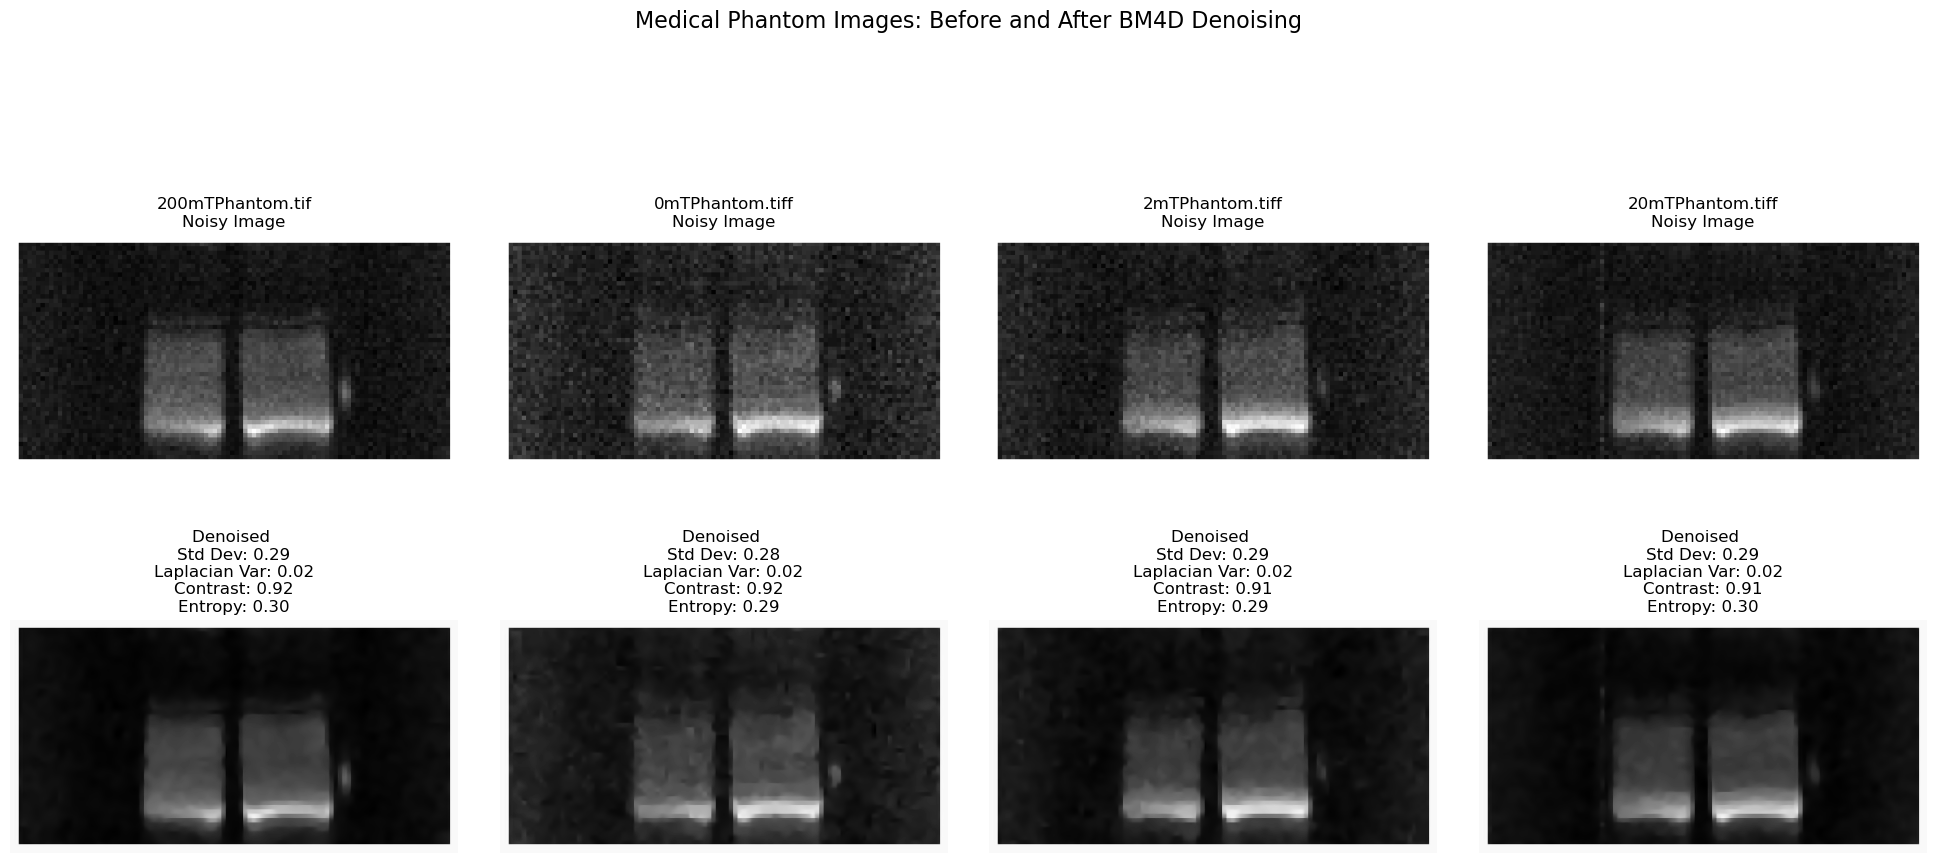

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import estimate_sigma
from skimage.color import rgb2gray, rgba2rgb
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage import io
import os
import bm4d


def compute_nr_iqa(image):
    """
    Calculates no-reference image quality assessment (NR-IQA) features for a given image.

    Args:
        image (np.ndarray): The grayscale image for which to calculate NR-IQA features.

    Returns:
        dict: A dictionary containing the calculated NR-IQA features:
            - Standard Deviation: Standard deviation of pixel intensity values.
            - Laplacian Variance: Variance of the Laplacian filter applied to the image.
            - Contrast (Michelson): Michelson contrast measure based on minimum and maximum intensities.
            - Entropy: Image entropy calculated using skimage.metrics.entropy.
    """

    std_dev = np.std(image)
    laplacian_img = laplace(image, ksize=3)  # Apply the Laplacian filter
    laplacian_var = np.var(laplacian_img)  # Compute the variance of the Laplacian
    contrast = (np.max(image) - np.min(image)) / (np.max(image) + np.min(image))
    # Calculate global entropy
    hist, _ = np.histogram(image, bins=256, range=(0, 256))
    prob_dist = hist / np.sum(hist)
    entropy_val = scipy_entropy(prob_dist, base=2)

    return {
        'Standard Deviation': std_dev,
        'Laplacian Variance': laplacian_var,
        'Contrast (Michelson)': contrast,
        'Entropy': entropy_val,
    }
def create_background_mask(image_gray):
    # Assumes image_gray is already a grayscale image
    thresh = threshold_otsu(image_gray)
    binary_image = image_gray <= thresh
    cleared_image = clear_border(binary_image)
    label_image = label(cleared_image)
    regions = regionprops(label_image)

    largest_area = 0
    background_label = 0
    for region in regions:
        if region.area > largest_area:
            largest_area = region.area
            background_label = region.label

    background_mask = label_image == background_label
    return background_mask

def denoise_medical_phantom(directory):
    file_list = [file for file in os.listdir(directory) if file.lower().endswith(('.tif', '.tiff'))]
    print("TIFF files found:", file_list)

    plt.figure(figsize=(20, 10))

    for i, filename in enumerate(file_list):
        image = io.imread(os.path.join(directory, filename))
        
        # Convert to grayscale if it's a multichannel image
        if image.ndim == 3 and image.shape[2] in [3, 4]:
            image = rgba2rgb(image) if image.shape[2] == 4 else image
            image_gray = rgb2gray(image)
        else:
            image_gray = image
        
        # Create a background mask for noise estimation
        background_mask = create_background_mask(image_gray)
        
        # Use the background mask to isolate background pixels for noise estimation
        background_pixels = image_gray[background_mask]
  
        
        # Apply BM4D Denoising using the estimated noise level from the background
        denoised_image = bm4d.bm4d(image_gray, sigma_psd=30/255, stage_arg=bm4d.BM4DStages.HARD_THRESHOLDING)
        
        # Calculate the standard deviation of the denoised image for comparison
        std_deviation_denoised = np.std(denoised_image[background_mask])
        
        nr_iqa_metrics = compute_nr_iqa(denoised_image)

        plt.subplot(2, len(file_list), i + 1)
        plt.imshow(image_gray, cmap='gray')
        plt.title(f'{filename}\nNoisy Image')
        plt.axis('off')

        plt.subplot(2, len(file_list), i + len(file_list) + 1)
        plt.imshow(denoised_image, cmap='gray')
        plt.title(f'Denoised \nStd Dev: {nr_iqa_metrics["Standard Deviation"]:.2f}\nLaplacian Var: {nr_iqa_metrics["Laplacian Variance"]:.2f}\nContrast: {nr_iqa_metrics["Contrast (Michelson)"]:.2f}\nEntropy: {nr_iqa_metrics["Entropy"]:.2f}')
        plt.axis('off')

    # Set custom ticks for x-axis based on the number of images
    x_ticks_positions = np.arange(len(file_list)) + 0.5  # +0.5 to center ticks if needed
    plt.xticks(x_ticks_positions, [str(x) for x in range(1, len(file_list) + 1)])

    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.85)
    plt.suptitle('Medical Phantom Images: Before and After BM4D Denoising', fontsize=16, y=0.98)
    plt.show()

# Example usage:
directory = '../TraditionalMethods/Experiments/PhantomData/3Dstackedupimages'
denoise_medical_phantom(directory)
